# Observações importantes
* Todas as análises, estatísticas e afirmações feitas nos comentários (markdowns) foram coletadas com o dataset completo, que é composto por 4 milhões de linhas. Porém, para agilizar o processo de desenvolvimento, foi coletada uma amostra aleatória de 50 mil registros;
* O conjunto de dados (data) é a junção de todos os anos (2009, 2010, 2011 e 2012);
* Este notebook foi construídos no Sagemaker, por isso o caminho de leitura do dado aponta para o S3. Mas o arquivo .parquet será disponibilizado para download.

# Instalando dependencias

In [1]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Importações

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Para tomar os dias da semana
from datetime import datetime
# Para o mapa
import folium

# Carregando os dados

In [3]:
data = pq.read_table("s3://dadosfera-dev/datalake/refined/nyctaxy/nyctaxi-trips.parquet").to_pandas()

# Análise Exploratória de Dados

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   dt_dropoff            object 
 1   nr_dropoff_latitude   float64
 2   nr_dropoff_longitude  float64
 3   vl_fare_amount        float64
 4   qt_passenger          int64  
 5   dt_pickup             object 
 6   nr_pickup_latitude    float64
 7   nr_pickup_longitude   float64
 8   cd_vendor             object 
 9   nm_vendor_name        object 
 10  vl_tip                float64
 11  vl_total              float64
 12  nr_trip_distance      float64
 13  nm_payment_type       object 
dtypes: float64(8), int64(1), object(5)
memory usage: 427.2+ MB


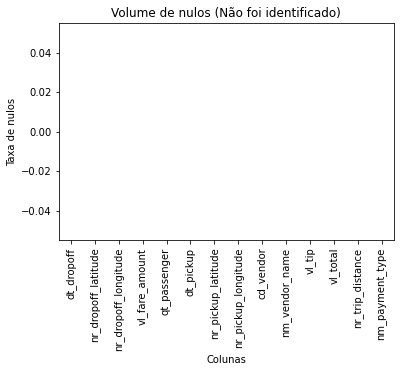

In [5]:
data.isna().sum().plot.bar()
plt.title('Volume de nulos (Não foi identificado)')
plt.xlabel('Colunas')
plt.ylabel('Taxa de nulos')
plt.show()

In [6]:
data.describe()

,nr_dropoff_latitude,nr_dropoff_longitude,vl_fare_amount,qt_passenger,nr_pickup_latitude,nr_pickup_longitude,vl_tip,vl_total,nr_trip_distance
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,4.013500e+01,-7.284804e+01,9.629421e+00,1.733573e+00,4.012473e+01,-7.283060e+01,4.085400e-01,1.032687e+01,2.678209e+00
std,4.986513e+00,9.050543e+00,7.567478e+00,1.254536e+00,5.026362e+00,9.122395e+00,1.258632e+00,8.503208e+00,3.130601e+00
min,-1.520200e-02,-7.919139e+01,2.500000e+00,0.000000e+00,-9.262000e-03,-8.487835e+01,0.000000e+00,2.500000e+00,0.000000e+00
25%,4.073537e+01,-7.399067e+01,5.400000e+00,1.000000e+00,4.073639e+01,-7.399112e+01,0.000000e+00,5.700000e+00,1.000000e+00
50%,4.075449e+01,-7.397953e+01,7.300000e+00,1.000000e+00,4.075453e+01,-7.398111e+01,0.000000e+00,7.800000e+00,1.700000e+00
75%,4.076952e+01,-7.396339e+01,1.090000e+01,2.000000e+00,4.076844e+01,-7.396681e+01,0.000000e+00,1.140000e+01,3.000000e+00
max,4.793581e+01,8.668000e-03,2.000000e+02,6.000000e+00,4.792285e+01,4.023000e-03,9.823000e+01,2.300000e+02,4.992000e+01


### Limpeza de dados

**Obs**: estas limpezas foram algumas inconsistências encontradas durante a análise, mas todos os pontos levantados aqui deveriam ser discutidos tanto com o time que fornece os dados quanto com o time de negócios. Dependendo do retorno, estas tratativas poderiam entrar nos pipelines de engenharia construídos no Glue, caso necessário.

In [7]:
def remove_outliers(column):
    # função para remover os outliers, tomando apenas valores entre o quantil 2% e 98%
    return data[data[column].between(data[column].quantile(0.02), data[column].quantile(0.98))]

In [8]:
# Existem latitudes e longitudes iguais a 0, o que faz com que as coordenadas caiam no meio do Oceano Atlântico, levando
# suspeitas em relação a qualidade dos dados. Optou-se então, para esta análise, remover estes outliers. Mas seria necessário
# uma investigação com o fornecedor dos dados e com o time de negócios para verificar se existe alguma regra de negócio 
# envolvida como, por exemplo, o destino não ser fornecido pelo cliente.
data = remove_outliers('nr_dropoff_latitude')
data = remove_outliers('nr_dropoff_longitude')
data = remove_outliers('nr_pickup_latitude')
data = remove_outliers('nr_pickup_longitude')

# Distância não deve ser negativa nem zerada
data = data.query('nr_trip_distance > 0.0')

# Nesta limpeza cabe a dúvida: serviços de delivery são considerados como "viagens sem passageiros"? Novamente, seria necessário
# verificar com os fornecedores dos dados e com o time de negócios.
data = data.query('qt_passenger > 0')

In [9]:
# IMPORTANTE
# Aqui é tomada a amostra de 50 mil registros explicada em "Observações importantes". Caso queira chegar nas estatísticas reais,
# basta remover/comentar a linha abaixo
data = data.sample(50000)

In [10]:
# Após limpeza
data.describe()

,nr_dropoff_latitude,nr_dropoff_longitude,vl_fare_amount,qt_passenger,nr_pickup_latitude,nr_pickup_longitude,vl_tip,vl_total,nr_trip_distance
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,40.753373,-73.977563,8.113060,1.736620,40.753612,-73.980059,0.321317,8.624791,2.042388
std,0.023389,0.019900,4.077706,1.255166,0.019497,0.015982,0.851198,4.493341,1.664543
min,40.639168,-74.011207,2.500000,1.000000,40.695712,-74.009330,0.000000,2.500000,0.010000
25%,40.739100,-73.990514,5.300000,1.000000,40.739494,-73.991110,0.000000,5.700000,0.960000
50%,40.755420,-73.980353,7.000000,1.000000,40.755222,-73.981950,0.000000,7.400000,1.550000
75%,40.768950,-73.967753,9.700000,2.000000,40.767143,-73.970873,0.000000,10.200000,2.600000
max,40.812633,-73.867712,59.100000,6.000000,40.797495,-73.911495,50.000000,78.120000,36.400000


## Número de passageiros

In [11]:
data.groupby('qt_passenger').size()

qt_passenger
1    32269
2     9220
3     2570
4     1491
5     4252
6      198
dtype: int64

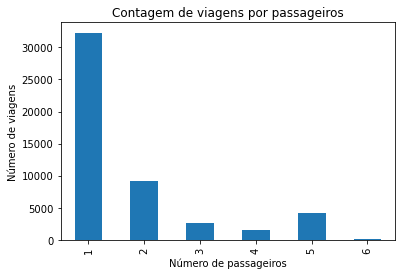

In [12]:
data.qt_passenger.value_counts().sort_index().plot.bar()
plt.title('Contagem de viagens por passageiros')
plt.xlabel('Número de passageiros')
plt.ylabel('Número de viagens')
plt.show()

### Qual a distância média percorrida por viagens com no máximo 2 passageiros?

A distância percorrida em viagens com até 2 passageiros é, em média, 2.02km (célula abaixo). 

Obs: não é especificado a unidade de medida (se é milhas ou quilômetro), assumirei quilômetros.

In [13]:
data.query('qt_passenger > 0 and qt_passenger <= 2').nr_trip_distance.mean()

2.0332276024970457

In [14]:
df_temp_number_passengers = data.qt_passenger.value_counts(normalize = True).to_frame()
df_temp_number_passengers['qt_passenger_cumsum'] = df_temp_number_passengers.qt_passenger.cumsum()
df_temp_number_passengers

,qt_passenger,qt_passenger_cumsum
1,0.64538,0.64538
2,0.18440,0.82978
5,0.08504,0.91482
3,0.05140,0.96622
4,0.02982,0.99604
6,0.00396,1.00000


Viagens com 1 passageiro representam 64.55% das viagens. Já viagens com 2 passageiros, 18.33%. Interessante observar que há um valor considerável de viagens com 5 passageiros (8,53%), até mesmo maior que com 3 pessoas (5,22%). Algum evento pode estar enviesando os dados. Talvez uma possível explicação é que jovens costumam ir ou retornar juntos de eventos e festas, chamando um mesmo táxi, ou até mesmo famílias indo para o aeroporto para iniciar uma viagem em família e por isso contratam um mesmo veículo... Resumindo, pode ser uma informação interessante ou mero acaso, mas se faz necessário uma investigação mais profunda para compreender este fenômeno.

### Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado?
Visualizando o gráfico acima, tem-se que **Creative Mobile Technologies, LLC** é o fornecedor que mais arrecadou, com um somatório, nos 4 anos, de 13950565.36 dólares, seguido pela **VeriFone Inc** (13356427.32 dólares), uma diferença de, aproximadamente, 2,58%. A terceira posição fica com a **Dependable Driver Service, Inc**, registrando um somatório de 1733328.68 dólares.

In [15]:
data.groupby(['cd_vendor', 'nm_vendor_name']).vl_total.sum().sort_values(ascending = False).to_frame()

,,vl_total
cd_vendor,nm_vendor_name,
CMT,"Creative Mobile Technologies, LLC",206808.42
VTS,VeriFone Inc,199232.09
DDS,"Dependable Driver Service, Inc",25199.05


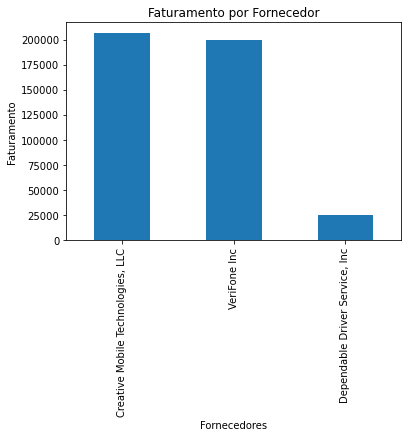

In [16]:
data.groupby('nm_vendor_name').vl_total.sum().sort_values(ascending = False).plot.bar()
plt.title('Faturamento por Fornecedor')
plt.xlabel('Fornecedores')
plt.ylabel('Faturamento')
plt.show()

## Faturamento por mês

In [17]:
# selecionando apenas pagamentos em dinheiro
# filtrando apenas as colunas que interessam para não duplicar o dataframe (pode causar problemas de memória)
df_datetime_in_cash = data.query("nm_payment_type == 'Cash'").copy()[['dt_pickup', 'vl_total']]

# colocando dt_pickup como índice para utilizar o resample
df_datetime_index = df_datetime_in_cash.set_index(df_datetime_in_cash.dt_pickup.astype('datetime64')).drop('dt_pickup', axis = 1)
df_datetime_index.head(10)

,vl_total
dt_pickup,
2012-02-09 16:43:29,6.2
2011-07-06 16:24:18,10.7
2012-06-03 11:32:44,7.7
2010-10-28 02:37:17,13.9
2011-08-23 15:23:07,15.3
2009-03-17 09:47:02,11.0
2010-08-13 11:07:51,15.4
2010-09-28 19:08:40,7.0
2009-08-25 21:16:59,15.4


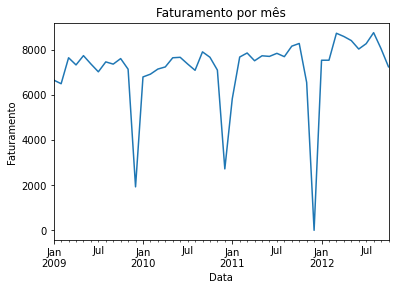

In [18]:
df_datetime_index.resample('m').vl_total.sum().plot()
plt.title('Faturamento por mês')
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.show()

### Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.

In [19]:
# reaproveitando df_datetime_in_cash anterior
df_month_vl_total = df_datetime_in_cash.copy()
# tomando o ano de dt_pickup
df_month_vl_total['dt_year'] = df_month_vl_total['dt_pickup'].astype('datetime64').apply(lambda date: date.year)
# tomando o mês de dt_pickup
df_month_vl_total['dt_month'] = df_month_vl_total['dt_pickup'].astype('datetime64').apply(lambda date: date.month)
df_month_vl_total.head(10)

,dt_pickup,vl_total,dt_year,dt_month
3474937,2012-02-09 16:43:29,6.2,2012,2
2407830,2011-07-06 16:24:18,10.7,2011,7
3449643,2012-06-03 11:32:44,7.7,2012,6
1439462,2010-10-28 02:37:17,13.9,2010,10
2264183,2011-08-23 15:23:07,15.3,2011,8
470579,2009-03-17 09:47:02,11.0,2009,3
1649351,2010-08-13 11:07:51,15.4,2010,8
1326806,2010-09-28 19:08:40,7.0,2010,9
594446,2009-08-25 21:16:59,15.4,2009,8
1285325,2010-07-01 00:06:03,10.2,2010,7


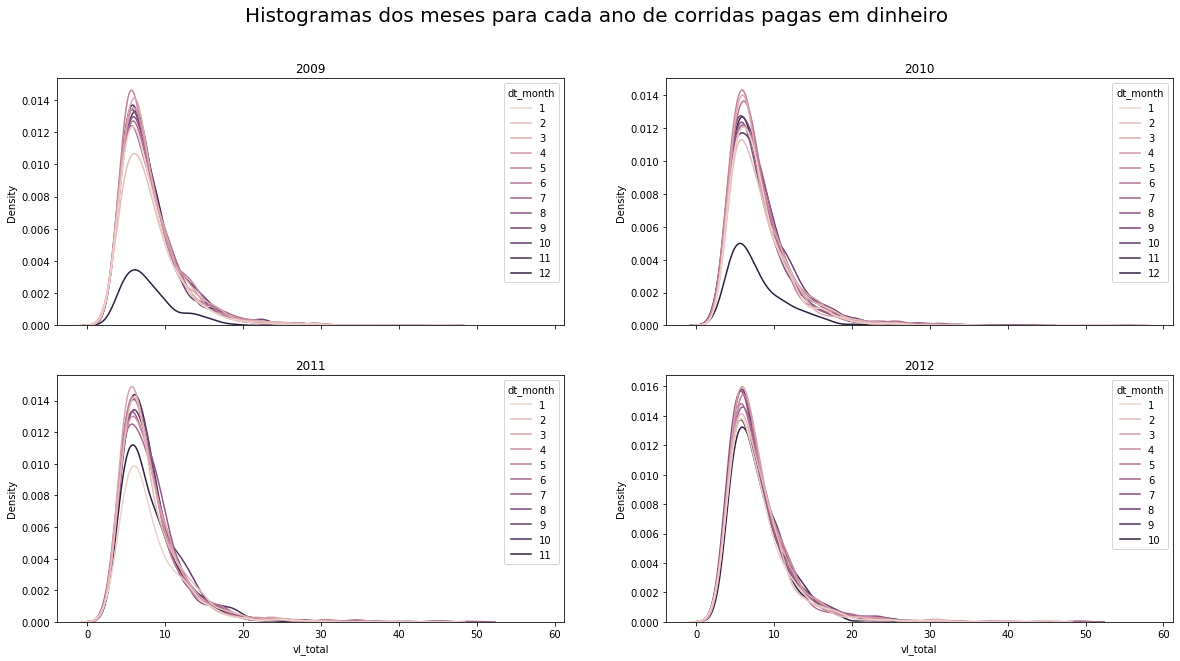

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

sns.kdeplot(data = df_month_vl_total.query('dt_year == 2009'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2010'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 1])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2011'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2012'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 1])

plt.suptitle("Histogramas dos meses para cada ano de corridas pagas em dinheiro", fontsize = 20)

ax[0, 0].title.set_text('2009')
ax[0, 1].title.set_text('2010')
ax[1, 0].title.set_text('2011')
ax[1, 1].title.set_text('2012')

Para melhorar a visualização, será feito um filtro de vl_total menor que 30.

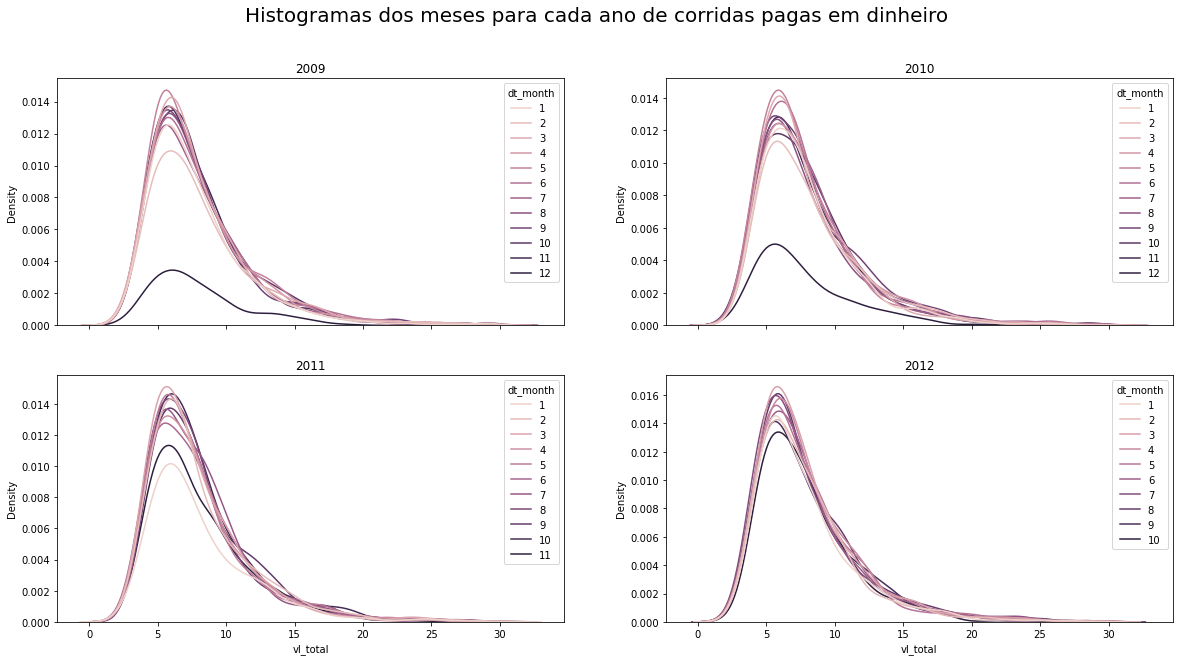

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

sns.kdeplot(data = df_month_vl_total.query('dt_year == 2009').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2010').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 1])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2011').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2012').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 1])

plt.suptitle("Histogramas dos meses para cada ano de corridas pagas em dinheiro", fontsize = 20)
    
ax[0, 0].title.set_text('2009')
ax[0, 1].title.set_text('2010')
ax[1, 0].title.set_text('2011')
ax[1, 1].title.set_text('2012')

### Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2011.

In [22]:
df_last_three_months_2011 = data.query("dt_pickup >= '2011-09-01 00:00:00' and dt_pickup <= '2011-12-31 23:59:59'")
df_last_three_months_2011 = df_last_three_months_2011.copy()[['dt_pickup', 'vl_tip']]

df_last_three_months_2011_indexed = df_last_three_months_2011.set_index(df_last_three_months_2011.dt_pickup.astype('datetime64')).drop('dt_pickup', axis = 1)
df_last_three_months_2011_indexed.head(10)

,vl_tip
dt_pickup,
2011-10-04 10:20:44,0.0
2011-11-04 03:41:45,0.0
2011-10-10 18:44:20,0.0
2011-09-03 16:06:21,0.0
2011-10-26 07:14:17,0.0
2011-09-24 06:50:37,1.0
2011-10-29 08:21:56,0.0
2011-09-29 08:51:44,0.0
2011-10-26 14:30:25,0.0


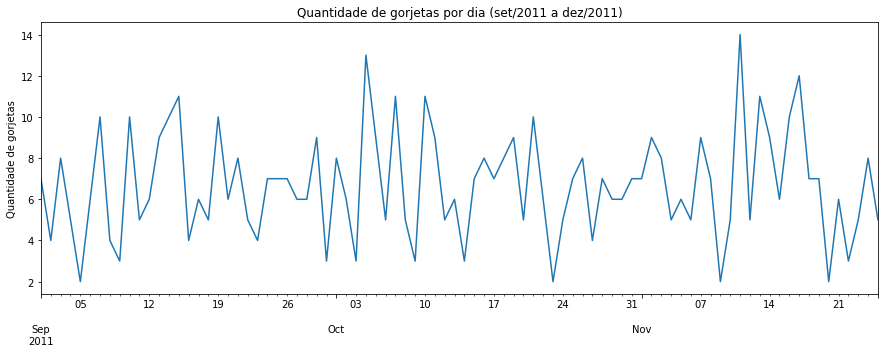

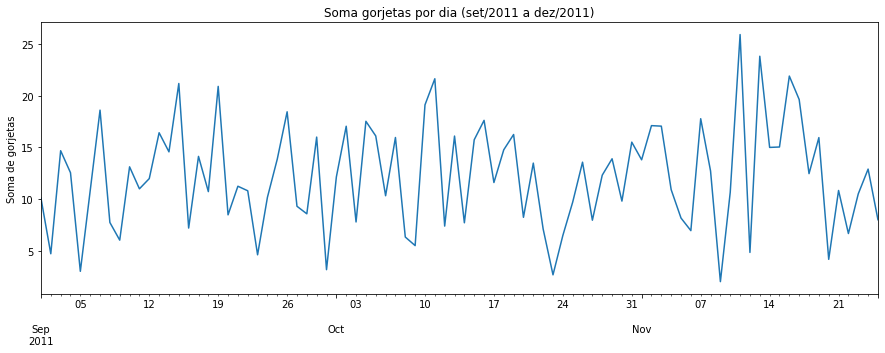

In [23]:
plt.figure(figsize = (15, 5))

# para pegar a quantidade, só foi transformados valores maiores que 0 (há gorjetas)
df_last_three_months_2011_indexed.vl_tip.apply(lambda x: 1 if (x > 0) else 0).resample('d').sum().plot()
plt.title('Quantidade de gorjetas por dia (set/2011 a dez/2011)')
plt.xlabel('')
plt.ylabel('Quantidade de gorjetas')

plt.figure(figsize = (15, 5))
df_last_three_months_2011_indexed.resample('d').vl_tip.sum().plot()
plt.title('Soma gorjetas por dia (set/2011 a dez/2011)')
plt.xlabel('')
plt.ylabel('Soma de gorjetas')
plt.show()

### Qual o tempo médio das corridas nos dias de semana.

In [24]:
# tomando o nome dos dias da semana baseado na dt_pickup
data['nm_weekday'] = data.dt_pickup.astype('datetime64').apply(lambda date: date.strftime('%A'))

In [25]:
# tomando a duração da viagem através da diferença entre desembarque e embarque
data['dt_trip_duration'] = data.dt_dropoff.astype('datetime64') - data.dt_pickup.astype('datetime64')

In [26]:
data.query("nm_weekday in ('Monday', 'Tuesday', 'Wednesday', 'Thuesday', 'Friday')").dt_trip_duration.mean()

Timedelta('0 days 00:08:44.005969211')

In [27]:
data.groupby('nm_weekday').dt_trip_duration.mean()

nm_weekday
Friday      0 days 00:08:45.899735412
Monday      0 days 00:08:45.635357548
Saturday    0 days 00:08:44.319568868
Sunday      0 days 00:08:47.633950007
Thursday    0 days 00:08:45.349887766
Tuesday     0 days 00:08:43.001379881
Wednesday   0 days 00:08:41.523357969
Name: dt_trip_duration, dtype: timedelta64[ns]

Pelo que é possível constatar acima, o tempo médio de viagem é de aproximadamente 8 minutos e 45 segundos. Descendo a um nível dia a dia, podemos constatar o mesmo padrão de tempo em todos os dias da semana. 

Uma possibilidade que explica esse evento seja o alto volume de viagens rotineiras como as corridas para o trabalho. Caberia uma investigação mais profunda: será que a grande maioria das viagens têm como destino o trabalho das pessoas?

### Fazer uma visualização em mapa com latitude e longitude de pickups and dropoffs no ano de 2010.

In [28]:
# Tomando apenas as coordenadas, neste caso vou ignorar as labels nos marcadores do mapa
# Além disso, peguei apenas uma amostra aleatória de 150 registros para uma melhor visualização
df_coordinates = data[['nr_pickup_latitude', 
                       'nr_pickup_longitude', 
                       'nr_dropoff_latitude', 
                       'nr_dropoff_longitude']].head(150)

df_coordinates.head(10)

,nr_pickup_latitude,nr_pickup_longitude,nr_dropoff_latitude,nr_dropoff_longitude
3474937,40.767680,-73.981438,40.755923,-73.981730
2407830,40.754535,-73.975645,40.724293,-73.998498
1117950,40.756918,-73.989203,40.742877,-73.977179
3449643,40.746985,-73.973345,40.750010,-73.993957
1439462,40.715317,-74.002022,40.671796,-73.981113
2264183,40.790529,-73.942582,40.750089,-73.998921
75636,40.765653,-73.972372,40.743087,-73.972327
2216207,40.720978,-73.997624,40.729248,-73.984145
470579,40.762052,-73.971663,40.731992,-73.994510
932732,40.731051,-73.991959,40.778636,-73.957614


Abaixo tem-se um mapa interativo com os pickups (em azul) e dropoffs (em verde). É possível perceber, com a imagem abaixo, onde se encontram a maioria de viagens, tanto o início como o fim.

In [30]:
map_new = folium.Map(location = [40.760912, -73.980867], zoom_start = 12)

df_pickup_coord = df_coordinates.values.tolist()

for i in df_pickup_coord:
    map_new.add_child(folium.Marker(location = [i[0], i[1]], icon = folium.Icon(color = 'blue')))
    map_new.add_child(folium.Marker(location = [i[2], i[3]], icon = folium.Icon(color = 'green')))

map_new